# 摘要

# 理论模型

## 相同标的的 ETF 组合

对于同一个指数, 可能有不同的基金公司发行的 ETF 产品. 因此在同一指数标的下不同的 ETF 产品之间应该存在协整性。然后不同产品也不时存在变动方向和变动幅度的不同步. 比如有些基金公司采用抽样法组建 ETF, 通过优选部分成分股复制指数来降低交易成本. 选择使用抽样法的 ETF 没有完全复制盯住指数中的成分证券, 因此相对于指数会不时发生较大的偏离.

跟踪相同标的的 ETF 的协整性将长期存在。

## 关联标的的 ETF 组合

关联标的的 ETF 主要有：
* 相似或者关联国家 ETF，比如：EWA（澳大利亚 ETF）与 EWC（加拿大 ETF），澳大利亚和加拿大均是依赖于商品贸易的经济体
* 相似或者关联行业 ETF，比如：金融 ETF（跟踪上证180金融股指数）, 金融行业 ETF（跟踪上证金融地产行业指数）
* 相关主题 ETF，比如：国企ETF（跟踪上证国有企业100指数）, 央企ETF
* 商品 ETF 以及生产该种商品的相关公司的股票 ETF，比如：GLD（SPDR 黄金 ETF），GDX（金矿指数 ETF）


## 包含相同成份的 ETF 组合

对于包含同一只股票的多只 ETF, 如果该股票发生了公司事件, 而 ETF 二级市场价格对该股票公司事件反应的预期不一样, 投资者可通过以下方法套利:
1. 买入二级市场价格相对低估的 ETF 品种;
2. 赎回交易价格低估的 ETF, 得到一揽子股票, 留下发生公司事件的股票
3. 将发生公司事件的股票配成交易价格相对高估 ETF 的一揽子股票, 申购份额并在二级市场卖出该 ETF

这样, 就获得了公司事件相对高估 ETF 与相对低估 ETF 之间的套利收益.

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

## ETF 组合的均值回归

将 ETF 基金按照跟踪的标的进行分类, 得到相同标的的 ETF 列表。

In [2]:
# 跟踪相同标的的 ETF
Today = dt.datetime.combine(dt.date.today(), dt.time(0))
WDB.connect()
ETFIDs = WDB.getTable("中国ETF申购赎回清单").getID(idt=Today)
ETFUnderlying = WDB.getTable("中国共同基金被动型基金跟踪指数").readData(factor_names=["跟踪指数Wind代码"], ids=ETFIDs, dts=[Today]).iloc[0, 0, :]
WDB.disconnect()
for iUnderlyingID, iETFIDs in ETFUnderlying.groupby(ETFUnderlying).groups.items():
    if iETFIDs.shape[0]>1: print(str(iUnderlyingID)+" : "+str(list(iETFIDs)))

000932.SH : ['159928.SZ', '512600.SH']
HSCEI.HI : ['159954.SZ', '159960.SZ', '510900.SH']
399975.SZ : ['512000.SH', '512570.SH', '512880.SH', '512900.SH']
000905.SH : ['159922.SZ', '159935.SZ', '510500.SH', '510510.SH', '510520.SH', '510550.SH', '510560.SH', '510580.SH', '510590.SH', '512500.SH', '512510.SH']
399986.SZ : ['512700.SH', '512800.SH', '512820.SH']
000934.SH : ['159931.SZ', '512640.SH']
716567.CSI : ['512160.SH', '512180.SH', '512280.SH', '512990.SH']
399006.SZ : ['159908.SZ', '159915.SZ', '159948.SZ', '159952.SZ', '159955.SZ', '159956.SZ', '159957.SZ', '159958.SZ']
716567.MI : ['512090.SH', '512520.SH']
399967.SZ : ['512560.SH', '512660.SH', '512680.SH', '512810.SH']
HSI.HI : ['159920.SZ', '513600.SH', '513660.SH']
000016.SH : ['510050.SH', '510600.SH', '510680.SH', '510710.SH', '510800.SH']
399001.SZ : ['159903.SZ', '159943.SZ', '159950.SZ']
000933.SH : ['159929.SZ', '512610.SH']
000300.SH : ['159919.SZ', '159925.SZ', '510300.SH', '510310.SH', '510330.SH', '510360.SH', '5

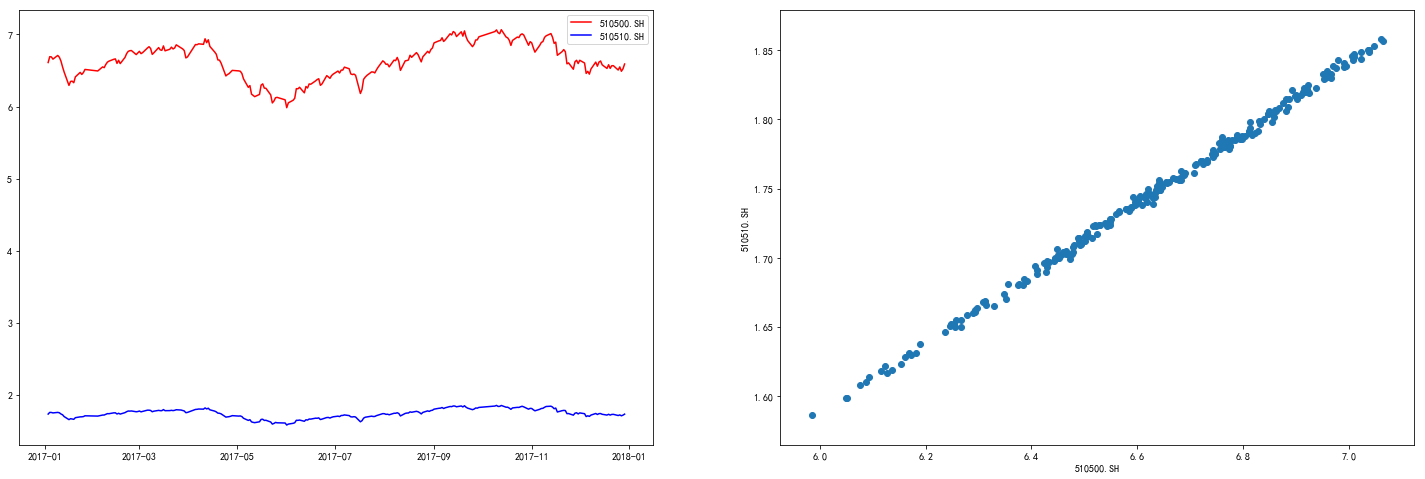

In [3]:
# 参数设置和数据准备
# 相同标的的 ETF
# IDs = ["510050.SH", "510710.SH"]# 50ETF, 上50ETF, 跟踪: 上证50指数, 万家50: 510680.SH; 上证50: 510800.SH
# IDs = ["510300.SH", "159919.SZ"]# 跟踪: 沪深300指数
IDs = ["510500.SH", "510510.SH"]# 跟踪: 中证500指数
# IDs = ["510500.SH", "159922.SZ"]# 跟踪: 中证500指数
# IDs = ['159928.SZ', '512600.SH']# 跟踪: 中证主要消费指数
# IDs = ['518800.SH', '518880.SH']# 跟踪: Au9999.SGE
# 相似标的的 ETF
# IDs = ["510270.SH", "510060.SH"]# 国企ETF, 央企ETF, 跟踪: 上证国有企业100指数, 上证中央企业 50 指数
# IDs = ["510230.SH", "510650.SH"]# 金融ETF, 金融行业ETF, 跟踪: 上证180金融股指数, 上证金融地产行业指数

StartDT = dt.datetime(2017, 1, 1)# 回测开始日期
EndDT = dt.datetime(2017, 12, 31)# 回测截止日期

WDB.connect()
DTs = WDB.getTable("中国A股交易日历").getDateTime(iid="SSE", start_dt=StartDT, end_dt=EndDT)
FT = WDB.getTable("中国封闭式基金日行情")
Price = FT.readData(factor_names=["收盘价(元)"], ids=IDs, dts=DTs).iloc[0,:,:]
AdjustFactor = FT.readData(factor_names=["复权因子"], ids=IDs, dts=DTs).iloc[0,:,:]
isLogPrice = False
WDB.disconnect()

# 对价格进行复权调整
AdjPrice = Price / AdjustFactor.iloc[-1] * AdjustFactor# 对价格前复权

# 取对数价格
# isLogPrice, Price = True, np.log(Price)

# 绘制价格图像
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(Price.index, Price.values[:, 0], color='r', label=Price.columns[0])
Axes[0].plot(Price.index, Price.values[:, 1], color='b', label=Price.columns[1])
Axes[0].legend(loc='best')
Axes[1].set_ylabel(Price.columns[1])
Axes[1].set_xlabel(Price.columns[0])
Axes[1].scatter(Price.values[:, 0], Price.values[:, 1]);

In [4]:
# --------平稳性检验--------
# ADF 检验
for i, iID in enumerate(IDs):
    ADFTest = sm.tsa.stattools.adfuller(Price.values[:, i], regression='c', autolag="BIC")
    print(("----------- %s 价格 ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]),
          ("pvalue : %f" % ADFTest[1]),
          ("usedlag : %d" % ADFTest[2]), sep="\n")
for i, iID in enumerate(IDs):
    ADFTest = sm.tsa.stattools.adfuller(np.diff(Price.values[:, i]), regression='c', autolag="BIC")
    print(("----------- Diff(%s 价格, 1) ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]), 
          ("pvalue : %f" % ADFTest[1]), 
          ("usedlag : %d" % ADFTest[2]), sep="\n")

----------- 510500.SH 价格 ADF Test ----------
Statistic : -1.942728
pvalue : 0.312235
usedlag : 0
----------- 510510.SH 价格 ADF Test ----------
Statistic : -1.912495
pvalue : 0.326206
usedlag : 0
----------- Diff(510500.SH 价格, 1) ADF Test ----------
Statistic : -16.013003
pvalue : 0.000000
usedlag : 0
----------- Diff(510510.SH 价格, 1) ADF Test ----------
Statistic : -15.801400
pvalue : 0.000000
usedlag : 0


In [5]:
# --------协整检验--------
CointADFTest = sm.tsa.stattools.coint(Price.values[:, 0], Price.values[:, 1:], trend="c", autolag="BIC")
print(("----------- %s-%s Cointegration ADF Test -----------" % tuple(Price.columns)),
      ("Statistic: %f" % CointADFTest[0]), 
      ("pvalue : %f" % CointADFTest[1]), sep="\n")

CointJohansenTest = sm.tsa.var.vecm.coint_johansen(Price.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- %s-%s Cointegration Johansen Test: r<=%d -----------" % (tuple(Price.columns)+(i, ))),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

----------- 510500.SH-510510.SH Cointegration ADF Test -----------
Statistic: -3.484777
pvalue : 0.033769
----------- 510500.SH-510510.SH Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 35.381344
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 31.799106
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- 510500.SH-510510.SH Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 3.582237
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 3.582237
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]


对冲比例: [ 1.         -3.92144934]


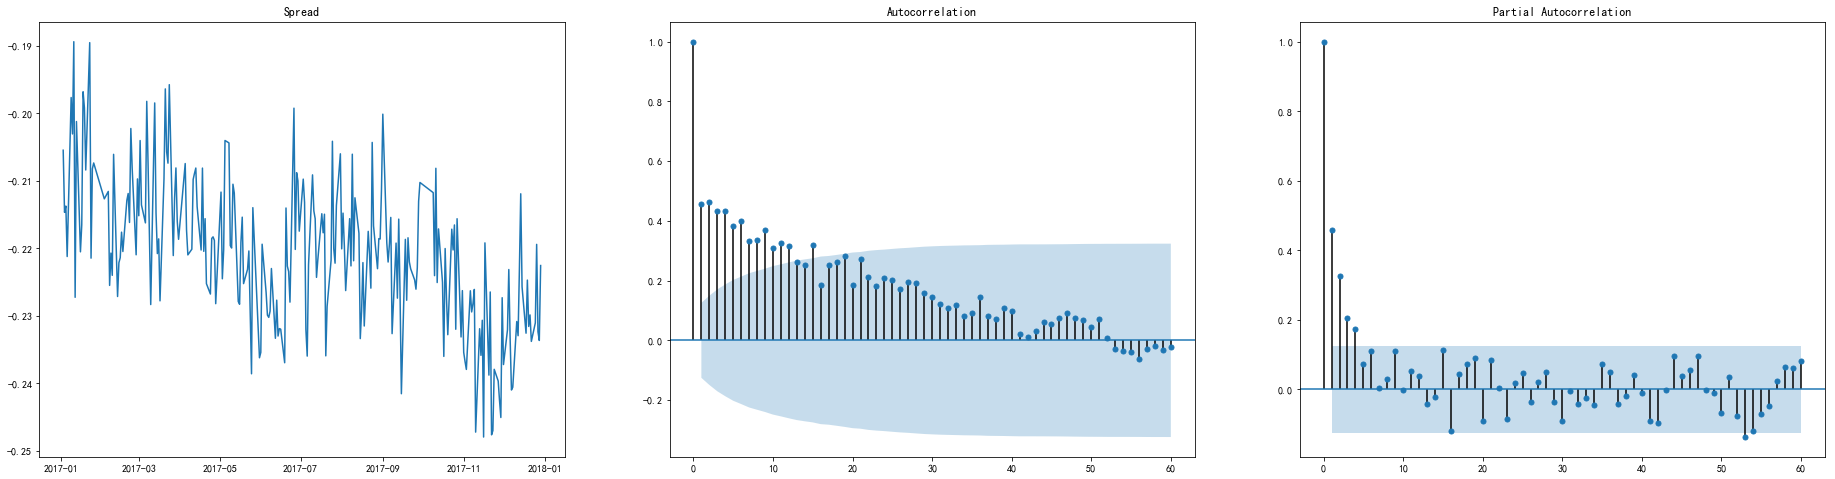

In [6]:
# 构造 Spread
HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (Price * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  244
Model:                     ARMA(1, 1)   Log Likelihood                 809.267
Method:                       css-mle   S.D. of innovations              0.009
Date:                Thu, 17 Jan 2019   AIC                          -1610.534
Time:                        14:02:59   BIC                          -1596.545
Sample:                             0   HQIC                         -1604.900
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2203      0.004    -57.411      0.000      -0.228      -0.213
ar.L1.y        0.9730      0.020     48.100      0.000       0.933       1.013
ma.L1.y       -0.7924      0.055    -14.390      0.0

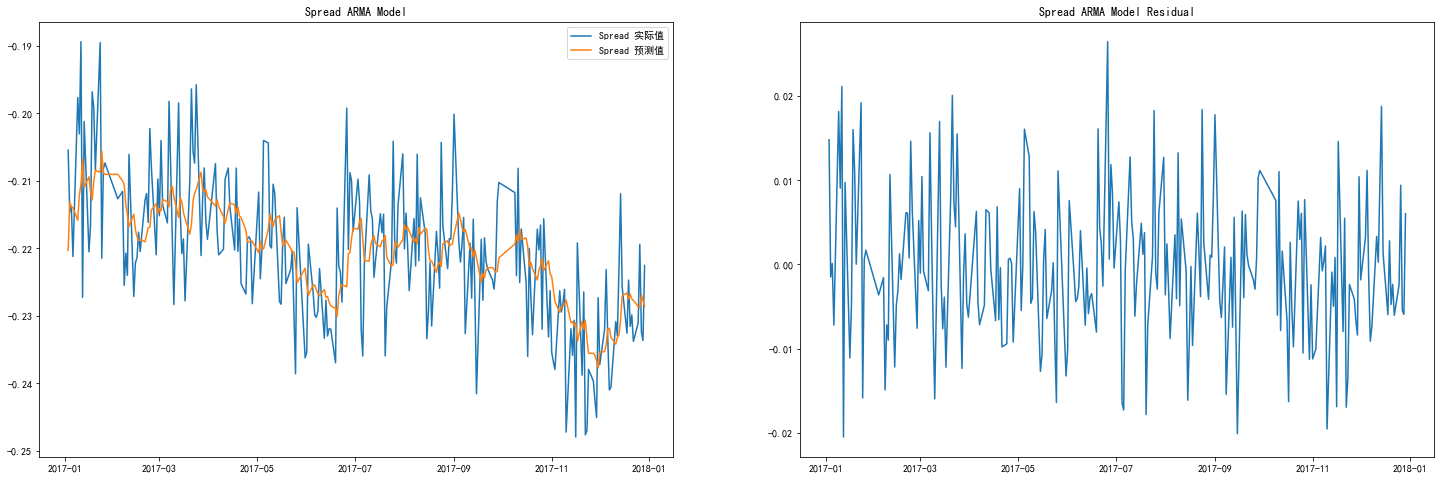

In [17]:
# 对 Spread 序列建立 ARMA 模型
# 确定 ARMA 模型的阶数
# ARMAOrder = sm.tsa.stattools.arma_order_select_ic(Spread.values, max_ar=10, max_ma=3, ic="bic", trend='c')
# ARMAOrder = ARMAOrder.bic_min_order
# print(ARMAOrder)
# 构建 ARMA 模型
ARMAOrder = (1, 1)
ARMAModel = sm.tsa.ARMA(Spread.values, order=ARMAOrder)
ARMARslt = ARMAModel.fit(trend="c", disp=False)
print(ARMARslt.summary())

Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(Spread.index, Spread.values, label="Spread 实际值")
Axes[0].plot(Spread.index, ARMARslt.fittedvalues, label="Spread 预测值")
Axes[0].legend(loc="best")
Axes[0].set_title("Spread ARMA Model")
Axes[1].plot(Spread.index, ARMARslt.resid)
Axes[1].set_title("Spread ARMA Model Residual");

HalfLife: 1.275738


,0
起始时点,2017-01-03 00:00:00
结束时点,2017-12-29 00:00:00
时点数,244
总收益率,0.108667
年化收益率,0.110257
年化波动率,0.0113192
Sharpe比率,9.74073
胜率,0.75
最大回撤率,0.00172776
最大回撤开始时点,2017-07-04 00:00:00


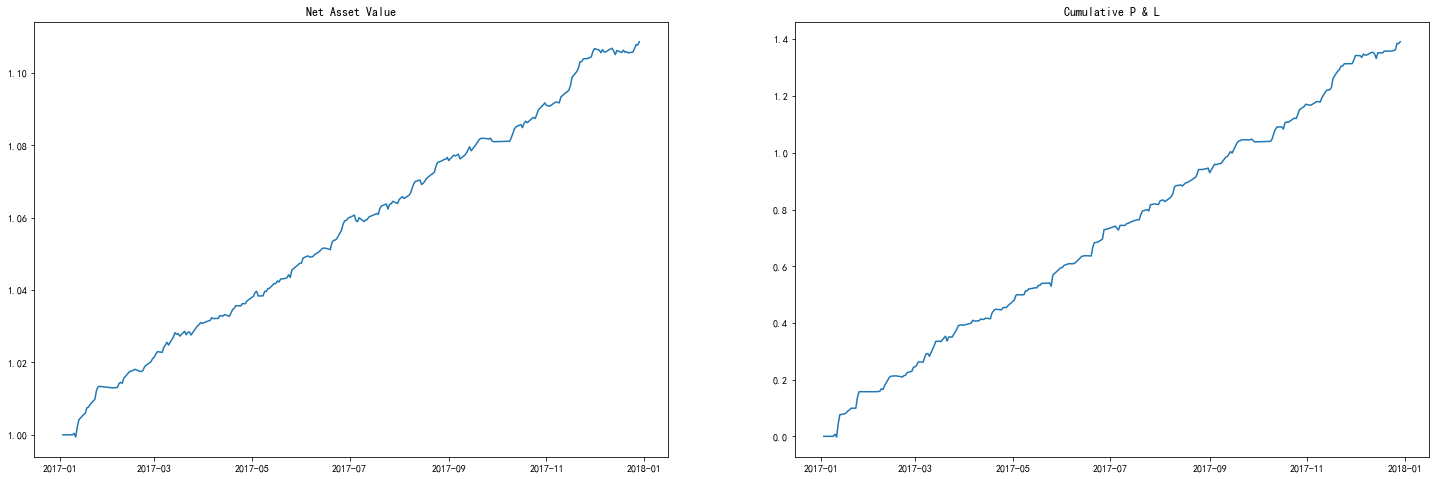

In [7]:
# --------线性均值回归策略--------
# 估计均值回复的半衰期
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)

LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.repeat(-Zscore.values.reshape((Zscore.shape[0], 1)), Price.shape[1], axis=1) * HedgeRatio
NumUnits[pd.isnull(NumUnits)] = 0
if isLogPrice: NumUnits /= Price.values
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * Price.values / AdjPrice.values, AdjPrice.values)
Return, PNL = pd.Series(Return, index=Price.index), pd.DataFrame(PNL, index=Price.index, columns=Price.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

HalfLife: 1.275738


,0
起始时点,2017-01-03 00:00:00
结束时点,2017-12-29 00:00:00
时点数,244
总收益率,0.0556518
年化收益率,0.0564462
年化波动率,0.00839601
Sharpe比率,6.72298
胜率,0.959016
最大回撤率,0.000964958
最大回撤开始时点,2017-03-20 00:00:00


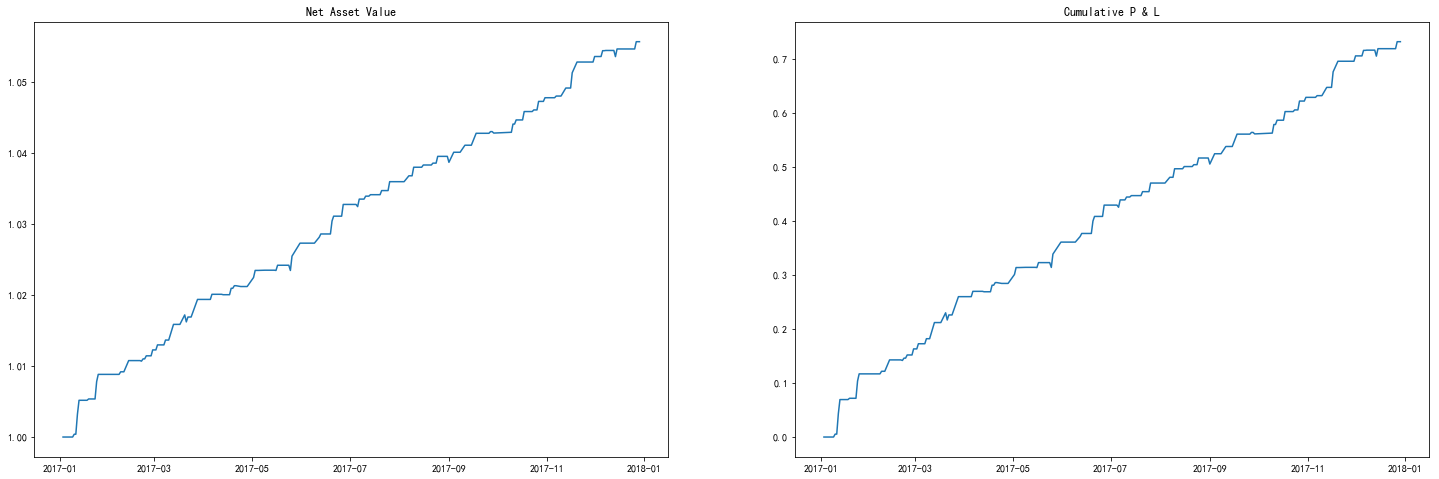

In [8]:
# --------基于 Bolling Band 的均值回归策略--------
EntryThreshold, ExitThreshold = 1, 0

# 估计均值回复的半衰期
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)

LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.zeros(Price.shape[0])
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
Mask = (np.abs(Zscore.values)<=ExitThreshold)
NumUnits[Mask] = 0
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(HedgeRatio.shape[0], axis=1) * HedgeRatio
if isLogPrice: NumUnits /= Price.values
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * Price.values / AdjPrice.values, AdjPrice.values)
Return, PNL = pd.Series(Return, index=Price.index), pd.DataFrame(PNL, index=Price.index, columns=Price.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");